![](https://raw.githubusercontent.com/fdannemanndugick/roses2021/main/header.png)

# Obtaining metadata and experimenting with response removal
The goal of this exercise is to explore different options in ObsPy's remove_response method and how they affect the output signal after deconvolution. Explore lots of different options, change the settings to request data from a station and earthquake of interest to you, and remember you can always re-start the notebook!  

You may want to start by taking a look at the documentation for remove_response: https://docs.obspy.org/packages/autogen/obspy.core.trace.Trace.remove_response.html

We'll start with the usual imports:

In [1]:
import obspy
from obspy.clients.fdsn import Client

# Edit client to use your data center of interest
client = Client("IRIS")


List of available clients: https://docs.obspy.org/packages/obspy.clients.fdsn.html

In [2]:
# Edit this to request metadata from your favorite station(s)
t1 = obspy.UTCDateTime("2020-07-01")
inv = client.get_stations(network="IW", station="PLID", channel="BHZ", level="response", starttime=t1)
inv += client.get_stations(network="GS", station="PR01", channel="HHZ", level="response", starttime=t1)
# may get a warning about StationXML1.1 -- OK to ignore it

/home/kdavidson/anaconda3/envs/roses/lib/python3.7/site-packages/obspy/io/stationxml/core.py:84: UserWarning: The StationXML file has version 1.1, ObsPy can deal with version 1.0. Proceed with caution.
  root.attrib["schemaVersion"], SCHEMA_VERSION))


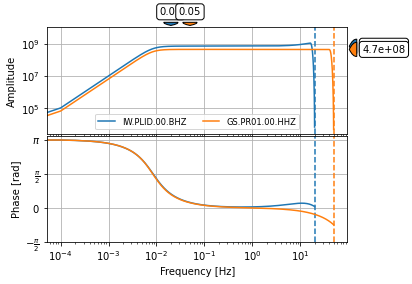

Inventory created at 2021-06-26T12:47:39.362563Z
	Created by: ObsPy 1.1.0
		    https://www.obspy.org
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (2):
			GS, IW
		Stations (2):
			GS.PR01 (PR01, Lajas)
			IW.PLID (Pearl Lake, Idaho, USA)
		Channels (2):
			GS.PR01.00.HHZ, IW.PLID.00.BHZ


ValueError: could not convert string to float: '#b15928'

In [4]:
inv.plot_response(min_freq=1e-4)
inv.write("inventory.xml", format="stationxml")
print(inv)
inv.plot();

Let's revisit the example Sydney showed in Unit 1 using the 2019 M7.1 Ridgecrest earthquake and GSN station IU.TUC in Tucson, Arizona.

In [ ]:
time = obspy.UTCDateTime("2019-07-06T03:19:53.04")
starttime = time - 60 
endtime = time + 60*15

net = "IU"
sta = "TUC"
loc = "00"
chan = "HH1"

# Requesting waveforms with attach_response=True tells ObsPy to request an inventory object for the channels requested
# st. 
st = client.get_waveforms(net, sta, loc, chan, starttime, endtime, attach_response = True)
print(st)

st_rem = st.copy() # make a copy of our original stream so we can try different options later

st_rem.remove_response(output = 'VEL', plot = True, water_level = 60) # Use ObsPy defaults to remove response
# What happens if you choose a different water_level?  What if you set water_level = 0?

st.plot()
st_rem.plot(color='red');

# Remember, if you remove the response from the same trace multiple times, your output will be strange (and non-physical).  
# This is why we make a new copy of st for each example below. 

By default, ObsPy removes the mean of the signal and applies a 5% cosine taper to the ends of the signal before removing the response: https://docs.obspy.org/packages/autogen/obspy.core.trace.Trace.remove_response.html

Let's explore what happens if we don't remove the mean or taper the signal. We'll also add a larger offset to the data to mimic a seismometer with masses that have drifted off-center (a common occurrence).

In [ ]:
st_rem = st.copy() # repeating this since the last cell will have removed the response from st_rem already

# ObsPy's remove_response command automatically removes the mean and applies a 5% taper
# This supresses low and high-frequency artifacts 
# What happens if you turn these off? 
# Let's add a big offset to the data to exaggerate the effects
st_rem[0].data = st_rem[0].data + 3e6
st_rem.remove_response(output = 'VEL', plot = True, taper=0, zero_mean=False) 

st.plot()
st_rem.plot(color='green');


You can also use the pre_filt option to apply a filter to your data before removing the response. This helps stabilize the deconvolution and avoids blowing up long-period noise.

In [ ]:
st_rem = st.copy() # repeating this since the last cell will have removed the response from st_rem already

# Use pre_filt command to filter the signal in your frequency band of interest
# Here's an example with pre_filt parameters useful for surface-wave studies
# Experiment with changing the 4 frequencies to see how this modifies the red pre_filt curve in the first row of plots
# Try modifying it to a frequency band that emphasizes body waves (~1 s) and filters out surface waves (~10s-100s of sec)
# Note: pre_filt is specified in Hz
# Remember: best not to work too close to Nyquist (highest freq should be no higher than about 0.75*fny)
print(st_rem[0].stats.sampling_rate)
st_rem.remove_response(output = 'VEL', plot = True, pre_filt=[0.0036, 0.006, 0.1, 0.5]) 

st.plot()
st_rem.plot(color='blue');